## Text classification with Word embeddings and LSTM

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!pip install tensorflow==1.12.0

     |████████████████████████████████| 83.1MB 1.2MB/s 
     |████████████████████████████████| 3.1MB 51.6MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [3]:
#Tensorflow
import tensorflow as tf
# Keras
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping

#Scikit-learn 
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

#Nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords

# Others
import pickle
import string
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Data preparation 

In [0]:
#Loading training dataset
with open('/content/gdrive/My Drive/Tesi/LDA2/Related/finale_LSTM.pickle', 'rb') as handle:
    training_data = pickle.load(handle)

In [0]:
training_data.head() #Balanced dataset: 166k record from SX (ETS and FAR), 160 from DX (T_D)

,text,pol_leaning
316946,Nothing to see here folks,0
261359,Get them while they're hot!,0
123106,"Nope, guess again.",1
187302,We should just let Nazi's be if they don't lis...,0
51288,Let the Trump Campaign know we do not support ...,1


In [0]:
t_features=training_data['text'] #features

In [0]:
labels=training_data['pol_leaning'] #labels

## FIRST ATTEMPT: Learning word embeddings directly from texts


### Text Preprocessing

In [0]:
# Adding to the stopwords list typical reddit words
stop_words = stopwords.words('english')
stop_words.extend(['reddit','subreddit','upvote','downvote','sub'])

In [0]:
#Removing 'not' from NLTK stopwords list, I want to keep negations
for elem in stop_words:
  if elem == 'not':
    stop_words.remove(elem)

In [0]:
### Text Normalizing function
def clean_text(text):
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stop_words)
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    ## Clean the text
    text=re.sub('(http:\/\/www\.|https:\/\/www\.|http:\/\/|https:\/\/|www\.)+(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '',text)
    text= re.sub('r\/','subred',text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    
    ## Remove puncuation
    text = re.sub(r'[^\w\s]','',text)

    ## Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    
    return text

In [0]:
# apply the above function to my texts
t_features = t_features.map(lambda x: clean_text(x))

In [0]:
t_features.head()

316946                                                             noth see folk
261359                                                          get they are hot
123106                                                          nope guess again
187302                          let nazi listen tri deal them all differ opinion
51288     let trump campaign know not support this centiped want legal marijuana
Name: text, dtype: object

In [0]:
info_text=t_features.map(lambda x: len(x)).describe() #info about submissions
info_text

count    326000.000000
mean         95.224077
std         290.859578
min           0.000000
25%          37.000000
50%          58.000000
75%          92.000000
max       24521.000000
Name: text, dtype: float64

In [0]:
### Tokenize text and Create sequence for LSTM
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(text1) #This method creates the vocabulary index based on word frequency (0 is reserved for padding)
sequences = tokenizer.texts_to_sequences(text1) #This method transforms each text in texts to a sequence of integers (the index created before)
data = pad_sequences(sequences, maxlen=80) #This method pads sequences to the same lenght (60)

In [0]:
num_types=len(tokenizer.word_index) #number of types in input dataset
num_types

143460

### Scikit-learn Grid search

I have employed the scikit-learn Grid Search in order to tuning the following hyperparameters:
* output_dim: number of dimension of the embeddings
* units: number of units in the LSTM layer

In [0]:
# Function to create model, required for KerasClassifier
def create_model(output_dim=50,units=32):
  # create model
    model = Sequential()
    model.add(Embedding(num_types+1, output_dim=output_dim, input_length=80, mask_zero=True))
    model.add(LSTM(units=units, dropout=0.3 recurrent_dropout=0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# split into input (X) and output (Y) variables
X = data
Y = labels

# create model
model = KerasClassifier(build_fn=create_model, epochs=7 , verbose=2)

In [0]:
# patient early stopping
es = EarlyStopping(monitor='loss', mode='auto', verbose=1, patience=2)

# define the grid search parameters
output_dim=[50,300] 
units=[32,128,256]
param_grid = dict(output_dim=output_dim,  units=units )
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=5)
grid_result = grid.fit(X, Y, callbacks=[es])

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Grid Search results

    Best: 0.815936 using {'dropout': 0.3, 'output_dim': 50, 'units': 32}
    0.815936 (0.001021) with: {'dropout': 0.3, 'output_dim': 50, 'units': 32}
    0.813607 (0.001910) with: {'dropout': 0.3, 'output_dim': 50, 'units': 128}
    0.813285 (0.001278) with: {'dropout': 0.3, 'output_dim': 50, 'units': 256}
    0.807304 (0.001459) with: {'dropout': 0.3, 'output_dim': 300, 'units': 32}
    0.808141 (0.001458) with: {'dropout': 0.3, 'output_dim': 300, 'units': 128}
    0.805739 (0.002262) with: {'dropout': 0.3, 'output_dim': 300, 'units': 256}

Plotting gridsearch result

Text(0.5, 1.0, 'Embedding fixed (50 units), dropout=0.3')

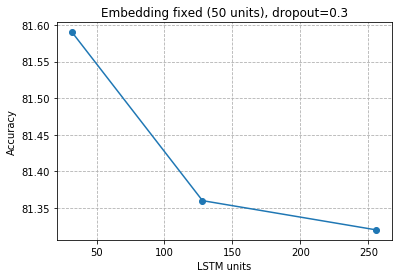

In [0]:
#embedding units fixed (50)
plt.plot ([32,128,256],[81.59,81.36,81.32],"o-")
plt.grid( linestyle='--')
plt.xlabel('LSTM units')
plt.ylabel('Accuracy')
plt.title('Embedding fixed (50 units), dropout=0.3')

Text(0.5, 1.0, 'Embedding fixed (300 units), dropout=0.3')

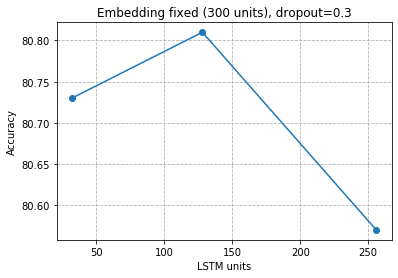

In [0]:
#embedding units fixed (300)
plt.plot ([32,128,256],[80.73,80.81,80.57],"o-")
plt.grid( linestyle='--')
plt.xlabel('LSTM units')
plt.ylabel('Accuracy')
plt.title('Embedding fixed (300 units), dropout=0.3')

### Best model with learned embeddings

I tried with an higher number of LSTM units (80) and I obtained a better accuracy and loss

In [0]:
#early stopping
es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
## Network architecture
model = Sequential()
model.add(Embedding(num_types+1, 80, input_length=80, mask_zero=True))
model.add(LSTM(80, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit the model
history=model.fit(data, np.array(labels), validation_split=0.2, epochs=4, shuffle=True ,callbacks=[es])




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





Train on 260800 samples, validate on 65200 samples
Epoch 1/4





260800/260800 [==============================] - 1669s 6ms/step - loss: 0.4435 - acc: 0.7897 - val_loss: 0.4052 - val_acc: 0.8118
Epoch 2/4
260800/260800 [==============================] - 1654s 6ms/step - loss: 0.3765 - acc: 0.8268 - val_loss: 0.3932 - val_acc: 0.8176
Epoch 3/4
260800/260800 [==============================] - 1655s 6ms/step - loss: 0.3429 - acc: 0.8430 - val_loss: 0.3917 - val_acc: 0.8197
Epoch 4/4
260800/260800 [==============================] - 1682s 6ms/step - loss: 0.3145 - acc: 0.8588 - val_loss: 0.3972 - val_acc: 0.8217


Neural Network architecture

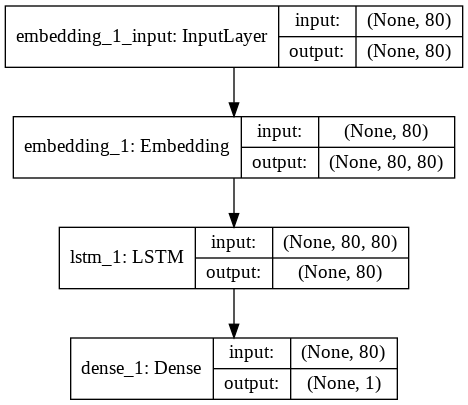

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

Plotting loss on training and test set

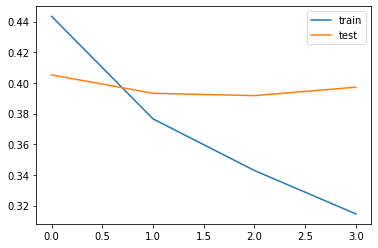

In [0]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Plotting accuracy on training and test set

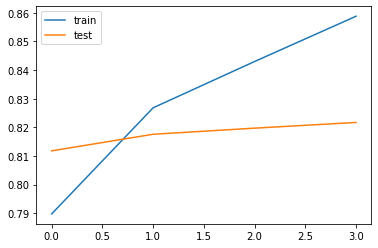

In [0]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

Saving model and weights

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("BESTmodelLEARNED.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("BESTmodelLEARNED.h5")
print("Saved model to disk")

Saved model to disk


## SECOND ATTEMPT: Using pre-trained Glove embeddings

### Text preprocessing

In [0]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(t_features)

# integer encode the documents
encoded_docs = t.texts_to_sequences(t_features)

# pad documents to a max length of 60 words (mean length is about 95)
padded_docs = pad_sequences(encoded_docs, maxlen=150, padding='post')

In [0]:
vocab_size=len(t.word_index)+1
vocab_size

56947

In [0]:
#transform labels from pandas series to numpy array
labels=np.asarray(labels) 

In [0]:
 #info about submissions
info_text1=t_features.map(lambda x: len(x)).describe()
info_text1

count    50000.000000
mean       149.891440
std        503.337603
min          2.000000
25%         53.000000
50%         89.000000
75%        146.000000
max      33813.000000
Name: text_and_title, dtype: float64

### GloVe word embeddings

In [0]:
#Loading embeddings
embeddings_index = dict()
f = open('/content/gdrive/My Drive/glove.6B.100d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

Loaded 400000 word vectors.


In [0]:
#Creating embedding matrix
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Final model

I trained the model on the whole data after trying it on the test set and obtaining the higher accuracy: 83%

In [0]:
#Early stopping
e = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1)
#Embedding layer
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=150, trainable=True) #Trainable = True to update weights during training
## Network architecture
model = Sequential()
model.add(e)
model.add(LSTM(80, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model.fit(padded_docs, labels, epochs=4, shuffle=True, callbacks=[es])











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/4
326000/326000 [==============================] - 2518s 8ms/step - loss: 0.5502 - acc: 0.6790
Epoch 2/4
326000/326000 [==============================] - 2567s 8ms/step - loss: 0.3753 - acc: 0.8311
Epoch 3/4
326000/326000 [==============================] - 2538s 8ms/step - loss: 0.3270 - acc: 0.8557
Epoch 4/4
326000/326000 [==============================] - 2496s 8ms/step - loss: 0.2956 - acc: 0.8707


Neural Network architecture

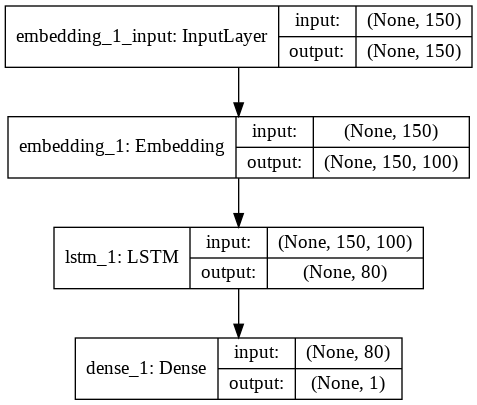

In [0]:
from keras.utils.vis_utils import plot_model
plot_model(loaded_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Plotting training and test loss

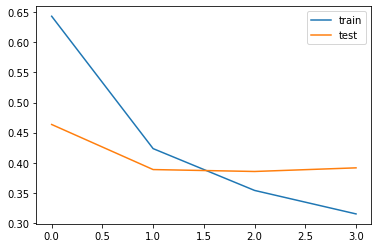

In [0]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Predictions

### Dataset

In [0]:
#loading model and weights
json_file = open('/content/gdrive/My Drive/Tesi/LDA2/Related/BESTMODELglove.json',  'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('/content/gdrive/My Drive/Tesi/LDA2/Related/BESTMODEL_weights_glove.h5')

In [0]:
#loading Tokenizer used to create word-index dictionary on training data
with open('/content/gdrive/My Drive/Tesi/LDA2/Related/tokenizer_GLOVE.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

I built the test data to make predictions on the final model: I pick new data from FAR, ETS and T_D (posts submitted from 2/05/19 to 1/12/19)

In [0]:
test_data=pd.read_json('/content/gdrive/My Drive/Tesi/LDA2/Related/test_data_LSTM_2.json') 

In [48]:
test_data.head()

,text_and_title,pol_leaning
37416,Trump's Crook Heading the Treasury Decided to Delay the Redesign of the $20 Bill so a Designer Releases 3D-Printed Stamp to Put Harriet Tubman on it Yourself.,0
28686,"2020 Hopeful Julian Castro on Trump's Racism, Breaking Up ICE, &amp; Amazon Strikes",0
33985,Hot take,0
13354,Why Are Kids Being Subjected To This?!,1
20029,When I hear that Hillary Clinton is considering running again in 2020...,1


In [0]:
real_labels=test_data['pol_leaning']

In [0]:
#applying tokenizer to test data
encoded_docs_test=tokenizer.texts_to_sequences(test_data['text_and_title'])
padded_docs_test=pad_sequences(encoded_docs_test,maxlen=150, padding='post')

Computing class predictions

In [51]:
class_pred = loaded_model.predict_classes(padded_docs_test)
np.unique(class_pred, return_counts=True)

(array([0, 1], dtype=int32), array([25148, 20137]))

In [0]:
predict_classes=class_pred.T

In [0]:
real_classes=real_labels.to_numpy()

Computing probabilty predictions

In [0]:
prob_pred= loaded_model.predict_proba(padded_docs_test)

In [0]:
prob_pred2=prob_pred.T

Visualizing test data and predictions

In [0]:
pd.options.display.max_colwidth=250

In [0]:
test_data['prob_pred']=prob_pred2[0]
test_data['class_pred']=predict_classes[0]
test_data['class_real']=real_classes

In [65]:
test_data.head()

,text_and_title,pol_leaning,prob_pred,class_pred,class_real
37416,Trump's Crook Heading the Treasury Decided to Delay the Redesign of the $20 Bill so a Designer Releases 3D-Printed Stamp to Put Harriet Tubman on it Yourself.,0,0.004415,0,0
28686,"2020 Hopeful Julian Castro on Trump's Racism, Breaking Up ICE, &amp; Amazon Strikes",0,0.005773,0,0
33985,Hot take,0,0.394364,0,0
13354,Why Are Kids Being Subjected To This?!,1,0.420787,0,1
20029,When I hear that Hillary Clinton is considering running again in 2020...,1,0.807433,1,1


In [78]:
len(test_data)

45285

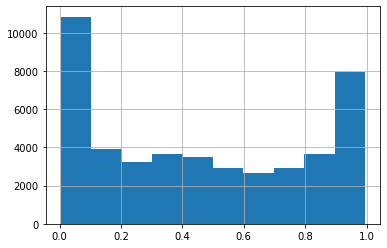

In [39]:
test_data['prob_pred'].hist()

Evaluating the model

In [43]:
# Python script for confusion matrix creation.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
actual = real_classes
predicted = predict_classes[0]
cf= confusion_matrix(actual, predicted)
print ('Confusion Matrix :')
print(cf)
print ('Accuracy Score :',accuracy_score(actual, predicted))
print('Classification Report : ')
print (classification_report(actual, predicted))

Confusion Matrix :
[[14627  6373]
 [10521 13764]]
Accuracy Score : 0.6269404880203158
Classification Report : 
              precision    recall  f1-score   support

           0       0.58      0.70      0.63     21000
           1       0.68      0.57      0.62     24285

    accuracy                           0.63     45285
   macro avg       0.63      0.63      0.63     45285
weighted avg       0.64      0.63      0.63     45285



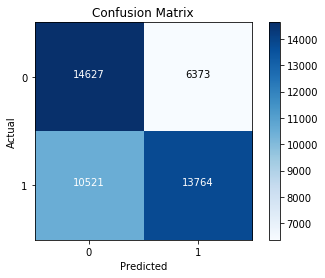

In [44]:
import itertools
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(expected))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show();

Looking at the distribution of probabilty predictions we can see that the values predicted correctly are mostly around 0.9 for pro-trump class and around 0.1 for anti-trump class.

In [0]:
correct_data= test_data[test_data['class_real'] == test_data['class_pred']]

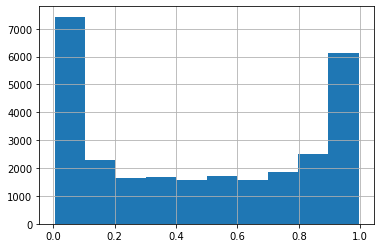

In [67]:
correct_data['prob_pred'].hist()

For the previous considerations I try to evalute the model only considering records with a probabilty prediction <= 0.15 (for the left party) or >= 0.85 (for the right party) , classifying remaining post as neutral

In [68]:
df_dx=test_data[test_data['prob_pred'] >= .85]
len(df_dx)

9842

In [69]:
df_sx = test_data[test_data['prob_pred'] <= .15]
len(df_sx)

12860

In [0]:
df_all=df_dx.append(df_sx, ignore_index=True)

In [72]:
df_all.head()

,text_and_title,pol_leaning,prob_pred,class_pred,class_real
0,"Include reddit.com/r/the_donald in your memes, so when people share them, new Pedes can find us and join. Now that we are quarantined, sharing is the only way!",1,0.978247,1,1
1,Well calibrated Outrage-o-meter,0,0.937973,1,0
2,"Yes Obama, I absolutely turned on you and can't wait till you are in Guantanamo Obama considers millions of voters switching from him to Trump turning on him. As a person not yet fully awakened to the true drivers behind all the shit that is wron...",1,0.936379,1,1
3,You will not find anything of value on MSM anymore.,1,0.981497,1,1
4,Dow is set to sink more than 270 points after Trump stuns markets with tariffs on Mexican imports,0,0.955090,1,0


In [75]:
#Model performance
actual = list(df_all['class_real'].values)
predicted = list(df_all['class_pred'].values)
cf= confusion_matrix(actual, predicted)
print ('Confusion Matrix :')
print(cf)
print ('Accuracy Score :',accuracy_score(actual, predicted))
print('Classification Report : ')
print (classification_report(actual, predicted))

Confusion Matrix :
[[8637 2376]
 [4223 7466]]
Accuracy Score : 0.7093207646903357
Classification Report : 
              precision    recall  f1-score   support

           0       0.67      0.78      0.72     11013
           1       0.76      0.64      0.69     11689

    accuracy                           0.71     22702
   macro avg       0.72      0.71      0.71     22702
weighted avg       0.72      0.71      0.71     22702



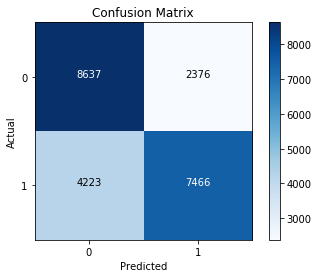

In [76]:
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(expected))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show();